In [29]:
import cv2
import numpy as np
import open3d as o3d
import os

def sift_keypoint_matching(img1, img2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # Use BFMatcher to match the descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.90 * n.distance:
            good_matches.append(m)
    
    return kp1, kp2, good_matches

def find_3D_points(depth_img, keypoints, matches, K):    
    
    fx =  K[2]
    fy =  K[3]
    cx =  K[4]
    cy =  K[5]
    
    points_3D = []
    for match in matches:
        u, v = keypoints[match.queryIdx].pt
        z = depth_img[int(v)][int(u)]
        
        if z:  # Only process if depth is not zero
            x = (u - cx) * z / fx
            y = (v - cy) * z / fy
            points_3D.append([x, y, z])
    
    return np.array(points_3D)


def gen_pcd(color, depth, K):
    
    camera_intrinsics = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsics.set_intrinsics(int(K[0]), int(K[1]), K[2], K[3], K[4], K[5])

    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False
    )

    volume = o3d.pipelines.integration.ScalableTSDFVolume(
        voxel_length=4.0 / 512.0, sdf_trunc=0.04, color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8
    )

    volume.integrate(rgbd, camera_intrinsics, np.eye(4))
    pcd = volume.extract_point_cloud()
    return pcd

def load_data(file_id, dpath):
   
    # Format filenames
    dpath = dpath.rstrip('/')

    # Split by the directory separator and get the last part
    suffix = os.path.basename(dpath)
    
    file_suffix = suffix + "_nano_" + str(file_id)
    # Construct full file paths using os.path.join for better cross-platform compatibility
    depth_file = os.path.join(dpath, file_suffix + "_depth.png")
    color_file = os.path.join(dpath, file_suffix + ".jpg")
    intrinsics_file = os.path.join(dpath, file_suffix + "_intrinsics.txt")
    
    # Read the files
    depth = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)
    rgb   = cv2.imread(color_file, cv2.IMREAD_GRAYSCALE)
    
    depth_o3d = o3d.io.read_image(depth_file)
    color_o3d = o3d.io.read_image(color_file)
    
    
    K = np.loadtxt(intrinsics_file)
    return depth, rgb, K, depth_o3d, color_o3d


path = '/home/vigir3d/Datasets/cattle_scans/Cattle_11_17_22/Animal_14_1/'
dpath = '/home/vigir3d/Datasets/cattle_scans/Cattle_11_17_22/Animal_1_1/'
file_ids = [11,12,14,16,17,18]  # exclude head cameras

depth1,rgb1, K1, depth_o3d1, rgb_o3d1 = load_data(file_ids[0], path) 
depth2,rgb2, K2, depth_o3d2, rgb_o3d2 = load_data(file_ids[1], path) 

pcd1 = gen_pcd(rgb_o3d1 , depth_o3d1, K1)
pcd2 = gen_pcd(rgb_o3d2 , depth_o3d2, K2)


kp1, kp2, matches = sift_keypoint_matching(rgb1, rgb2)

depth_points1 = find_3D_points(depth1, kp1, matches, K1)
depth_points2 = find_3D_points(depth2, kp2, matches, K2)

In [9]:
o3d.visualization.draw_geometries([pcd1,pcd2])

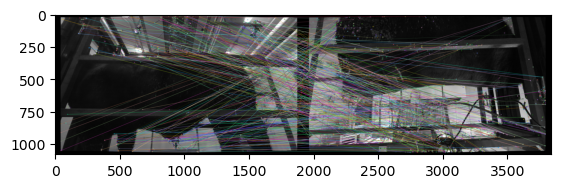

In [30]:
import matplotlib.pyplot as plt
# Draw matches
img_matches = cv2.drawMatches(rgb1, kp1, rgb2, kp2, matches, None)
plt.imshow(img_matches)
plt.show()

In [31]:

# Assuming you already have depth_points1 and depth_points2 from previous steps

# Convert the 3D points to PointCloud format
pcdd1 = o3d.geometry.PointCloud()
pcdd1.points = o3d.utility.Vector3dVector(depth_points1)

pcdd2 = o3d.geometry.PointCloud()
pcdd2.points = o3d.utility.Vector3dVector(depth_points2)

# For visualization purposes, you might want to transform the second point cloud 
# (just to visually separate the two point clouds. This is optional).
# transformation_matrix = np.eye(4)
# transformation_matrix[0, 3] = 0.5  # Translation in x
# pcd2.transform(transformation_matrix)

# Draw the two point clouds together
o3d.visualization.draw_geometries([pcdd1, pcdd2])


In [24]:
import copy
import teaserpp_python
from numpy.linalg import inv
from scipy.spatial import cKDTree

def register_SIFT_teaser(pts1, pts2, A_pcd_raw, B_pcd_raw):
    VOXEL_SIZE = 0.05
    # ADD FPFH Features also:
    A_pcd = A_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)
    B_pcd = B_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)

    A_xyz = pcd2xyz(A_pcd) # np array of size 3 by N
    B_xyz = pcd2xyz(B_pcd) # np array of size 3 by M

    print("Extracting FPFH features")
    # extract FPFH features
    A_feats = extract_fpfh(A_pcd,VOXEL_SIZE)
    B_feats = extract_fpfh(B_pcd,VOXEL_SIZE)
    print("Computing FPFH correspondences")
    # establish correspondences by nearest neighbour search in feature space
    corrs_A, corrs_B = find_correspondences(
        A_feats, B_feats, mutual_filter=True)
    A_corr = A_xyz[:,corrs_A] # np array of size 3 by num_corrs
    B_corr = B_xyz[:,corrs_B] # np array of size 3 by num_corrs

    num_corrs = A_corr.shape[1]
    print(f'FPFH generates {num_corrs} putative correspondences.')
   
    # Augmenting the correspondences
    A_combined = np.hstack([pts1.T, A_corr])
    B_combined = np.hstack([pts2.T, B_corr])

    NOISE_BOUND = 0.05
    teaser_solver = get_teaser_solver(NOISE_BOUND)
    teaser_solver.solve(A_combined,B_combined)
    solution = teaser_solver.getSolution()
    R_teaser = solution.rotation
    t_teaser = solution.translation
    T_teaser = Rt2T(R_teaser,t_teaser)
    return T_teaser
    
def register_two_views_teaser(A_pcd_raw,B_pcd_raw,VOXEL_SIZE):
    
    VISUALIZE = True
    A_pcd = A_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)
    B_pcd = B_pcd_raw.voxel_down_sample(voxel_size=VOXEL_SIZE)
    #if VISUALIZE:
     #   o3d.visualization.draw_geometries([A_pcd,B_pcd]) # plot downsampled A and B 

    A_xyz = pcd2xyz(A_pcd) # np array of size 3 by N
    B_xyz = pcd2xyz(B_pcd) # np array of size 3 by M

    print("Extracting FPFH features")
    # extract FPFH features
    A_feats = extract_fpfh(A_pcd,VOXEL_SIZE)
    B_feats = extract_fpfh(B_pcd,VOXEL_SIZE)
    print(A_feats.shape)
    print("Computing FPFH correspondences")
    # establish correspondences by nearest neighbour search in feature space
    corrs_A, corrs_B = find_correspondences(
        A_feats, B_feats, mutual_filter=True)
    A_corr = A_xyz[:,corrs_A] # np array of size 3 by num_corrs
    B_corr = B_xyz[:,corrs_B] # np array of size 3 by num_corrs

    num_corrs = A_corr.shape[1]
    print(f'FPFH generates {num_corrs} putative correspondences.')

    # visualize the point clouds together with feature correspondenc
    # robust global registration using TEASER++
    NOISE_BOUND = VOXEL_SIZE
    teaser_solver = get_teaser_solver(NOISE_BOUND)
    print("Input shape: " ,A_corr.shape)
    teaser_solver.solve(A_corr,B_corr)
    solution = teaser_solver.getSolution()
    R_teaser = solution.rotation
    t_teaser = solution.translation
    T_teaser = Rt2T(R_teaser,t_teaser)

    # Visualize the registration results
    A_pcd_T_teaser = copy.deepcopy(A_pcd).transform(T_teaser)
    #o3d.visualization.draw_geometries([A_pcd_T_teaser,B_pcd])

    # local refinement using ICP
    icp_sol = o3d.pipelines.registration.registration_icp(
          A_pcd, B_pcd, NOISE_BOUND, T_teaser,
          o3d.pipelines.registration.TransformationEstimationPointToPoint(),
          o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))
    T_icp = icp_sol.transformation

    # visualize the registration after ICP refinement
    A_pcd_T_icp = copy.deepcopy(A_pcd).transform(T_icp)
    if VISUALIZE:
        Acopy = copy.deepcopy(A_pcd_T_icp).paint_uniform_color([0.0,0.0,1])
        Bcopy = copy.deepcopy(B_pcd).paint_uniform_color([1.0,0.0,0.0])
        o3d.visualization.draw_geometries([Acopy,Bcopy])
    tformed_A = copy.deepcopy(A_pcd_raw).transform(T_icp)
    res = o3d.geometry.PointCloud()
    res = tformed_A + B_pcd_raw
    
    return res,T_icp

def pcd2xyz(pcd):
    return np.asarray(pcd.points).T

def extract_fpfh(pcd, voxel_size):
    radius_normal = voxel_size * 2
    pcd.estimate_normals(
      o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
      pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return np.array(fpfh.data).T

def find_knn_cpu(feat0, feat1, knn=1, return_distance=False):
    feat1tree = cKDTree(feat1)
    dists, nn_inds = feat1tree.query(feat0, k=knn, workers=10)
    if return_distance:
        return nn_inds, dists
    else:
        return nn_inds

def find_correspondences(feats0, feats1, mutual_filter=True):
    nns01 = find_knn_cpu(feats0, feats1, knn=1, return_distance=False)
    corres01_idx0 = np.arange(len(nns01))
    corres01_idx1 = nns01

    if not mutual_filter:
        return corres01_idx0, corres01_idx1

    nns10 = find_knn_cpu(feats1, feats0, knn=1, return_distance=False)
    corres10_idx1 = np.arange(len(nns10))
    corres10_idx0 = nns10

    mutual_filter = (corres10_idx0[corres01_idx1] == corres01_idx0)
    corres_idx0 = corres01_idx0[mutual_filter]
    corres_idx1 = corres01_idx1[mutual_filter]

    return corres_idx0, corres_idx1

def get_teaser_solver(noise_bound):
    solver_params = teaserpp_python.RobustRegistrationSolver.Params()
    solver_params.cbar2 = 1.0
    solver_params.noise_bound = noise_bound
    solver_params.estimate_scaling = False
    solver_params.inlier_selection_mode = \
        teaserpp_python.RobustRegistrationSolver.INLIER_SELECTION_MODE.PMC_EXACT
    solver_params.rotation_tim_graph = \
        teaserpp_python.RobustRegistrationSolver.INLIER_GRAPH_FORMULATION.CHAIN
    solver_params.rotation_estimation_algorithm = \
        teaserpp_python.RobustRegistrationSolver.ROTATION_ESTIMATION_ALGORITHM.GNC_TLS
    solver_params.rotation_gnc_factor = 1.4
    solver_params.rotation_max_iterations = 10000
    solver_params.rotation_cost_threshold = 1e-16
    solver = teaserpp_python.RobustRegistrationSolver(solver_params)
    return solver

def Rt2T(R,t):
    T = np.identity(4)
    T[:3,:3] = R
    T[:3,3] = t
    return T


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])


In [32]:
T = register_SIFT_teaser(depth_points1, depth_points2, pcd1, pcd2)
draw_registration_result(pcd1,pcd2,T)

Extracting FPFH features
Computing FPFH correspondences
FPFH generates 448 putative correspondences.
Starting scale solver (only selecting inliers if scale estimation has been disabled).
Scale estimation complete.
Max core number: 9
Num vertices: 604
Created adjacency matrix in 4.3869e-05 seconds
[pmc: initial k-core pruning]  before pruning: |V| = 603, |E| = 3122
[pmc: initial k-core pruning]  after pruning:  |V| = 440, |E| = 3088
[pmc]  initial pruning took 1.40667e-05 sec
[pmc: sorting neighbors]  |E| = 6176, |E_sorted| = 6176
-----------------------------------------------------------------------
Max Clique of scale estimation inliers: 
Using chain graph for GNC rotation.
Starting rotation solver.
GNC rotation estimation noise bound:0.1
GNC rotation estimation noise bound squared:0.01
GNC-TLS solver terminated due to cost convergence.
Cost diff: 0
Iterations: 28
Rotation estimation complete.
Starting translation solver.
Translation estimation complete.
